## Кластеризация покупателей
Задача: Кластеризация покупателей в зависимости от их профиля (возраста, гендера, годового дохода или оценки расходов)

План:
1. Предобработка данных
2. DBSCAN
3. Иерархическая кластеризация

In [2]:
# импортируем библиотеки для работы с данными
import pandas as pd
from sklearn import preprocessing 

# загрузим данные
df = pd.read_csv("data\segmented_customers.csv")
# посмотрим на данные
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),cluster
0,1,Male,19.0,15.0,39.0,4.0
1,2,Male,21.0,15.0,81.0,3.0
2,3,Female,20.0,16.0,6.0,4.0
3,4,Female,23.0,16.0,77.0,3.0
4,5,Female,31.0,17.0,40.0,4.0


### 1. Предобработка данных

Проведём предобработку данных: удалим пропуски и дубли, признак Gender превратим в бинарный с помощью LabelEncoder:

In [3]:
# посмотрим, есть ли пропуски в датасете
df[df.isna().any(axis=1)]

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),cluster
200,201,Female,21.0,NaN,40.0,0.0
201,202,Female,30.0,127.0,NaN,NaN
202,203,Male,80.0,NaN,20.0,NaN
203,204,Male,NaN,16.0,120.0,NaN
204,205,Female,NaN,9.0,80.0,NaN


In [4]:
# пропусков не так много, поэтому мы можем удалить данные с пропусками
df = df.dropna()

# переименуем столбцы для более удобной работы
df.rename(columns = {'CustomerID' : 'customer_id', 'Gender' : 'gender', 
                    'Age': 'age', 'Annual Income (k$)': 'annual_income', 
                    'Spending Score (1-100)': 'spending_score', }, inplace = True)

In [5]:
# проверим, есть ли в данных дубликаты
df[df.duplicated(subset=['customer_id'])]

,customer_id,gender,age,annual_income,spending_score,cluster


Дубликатов нет, поэтому идём дальше.

3
Чтобы мы могли визуально оценивать результаты кластеризации, будем проводить её по трём признакам, а именно: годовой заработок, коэффициент покупательской способности и возраст. Визуализируем распределение данных:

In [6]:
import plotly
import plotly.express as px

# передаём датафрейм и поля, которые нужно использовать для осей абсцисс, ординат и аппликат
fig = px.scatter_3d(
    data_frame=df, 
    x = 'age', 
    y = 'annual_income', 
    z = 'spending_score', 
    width=1000,
    height=700
)

#отображаем график
fig.show()

Так как нам часто будет требоваться визуализировать результаты кластеризации, напишем для этого функцию. Она будет принимать датафрейм и название столбца датафрейма с результатами кластеризации. Так как нас будут стабильно интересовать три столбца (age, annual_income, spending_score), зафиксируем их названия внутри функции:

In [7]:
def get_3d_visualization(df, clust_res):
    fig = px.scatter_3d(
        data_frame=df, 
        x = 'age', 
        y = 'annual_income', 
        z = 'spending_score', 
        color = clust_res,
        width=1000,
        height=700
    )

    #возвращаем график
    return fig

Сохраним признаки, по которым будем проводить моделирование, в переменную X:

In [8]:
X = df[['age', 'annual_income', 'spending_score']]

### 2. DBSCAN

Как мы видим, данные разрежённые и неоднородные, а значит, применять DBSCAN будет сложно, нужно будет подбирать параметры для кластеризации.

Попробуйте провести DBSCAN-кластеризацию со значениями по умолчанию. Сколько кластеров у вас получилось?

In [16]:
# импортируем DBSCAN кластеризацию
from sklearn.cluster import DBSCAN

#запускаем кластеризацию на наших данных
clustering = DBSCAN().fit(X)

# визуализация
get_3d_visualization(df, clustering.labels_)

Как видно, алгоритм плохо работает с настройками по умолчанию, поэтому попробуем изменить их.

Большая часть наших данных разрежённые, а чем больше разброс точек в датасете, тем большее значение радиуса вокруг точки (eps) нужно задавать. Так как данные разрежённые, попробуем увеличить значение eps до 11 и визуально оценим результат:

In [18]:
# импортируем DBSCAN-кластеризацию
from sklearn.cluster import DBSCAN

#запускаем кластеризацию на наших данных
dbscan = DBSCAN(eps=11)
clustering_dbscan_res = dbscan.fit_predict(X)
df['dbscan_res_eps_11'] = clustering_dbscan_res

get_3d_visualization(df, 'dbscan_res_eps_11')

Распределение данных неоднородно: в одной области они имеют высокую плотность, в другой области — разряжены. Такие данные не подходят для успешной кластеризации алгоритмом DBSCAN.

### 3. Агломеративная или иерархическая кластеризация

Проведём агломеративную кластеризацию, чтобы построить дендрограмму и по ней оценить количество кластеров, на которое можно разделить датасет. Напишем функцию, которая будет принимать количество кластеров и матрицу с признаками:

In [21]:
# импортируем алгомеративную кластеризацию из sklearn
from sklearn.cluster import AgglomerativeClustering

# напишем функцию, которая будет проводить алгомеративную кластеризацию
# на вход она будет принимать X — матрицу с признаками для кластеризации и n_clusters — количество кластеров,
# на выходе будет возвращать список с номерами кластеров
def get_aggl_clustering(X, n_clusters):
    # запустим агломеративную кластеризацию
    agglomerative_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    # обучим модель агломеративной кластеризации
    agglomerative_clustering.fit(X)
    # получим список c информацией, к какому кластеру относятся объекты
    aggl_prediction = agglomerative_clustering.labels_
    # вернём список с результатами
    return aggl_prediction

predictions_ag_model = get_aggl_clustering(X, 3)

Теперь, вооружившись знаниями из юнита про иерархическую кластеризацию, самостоятельно проведите агломеративную кластеризацию, воспользовавшись функцией, которую мы только что написали. После этого визуализируйте полученную дендрограмму. Количество кластеров для кластеризации укажите равным 3 (на данном этапе это не очень важно).

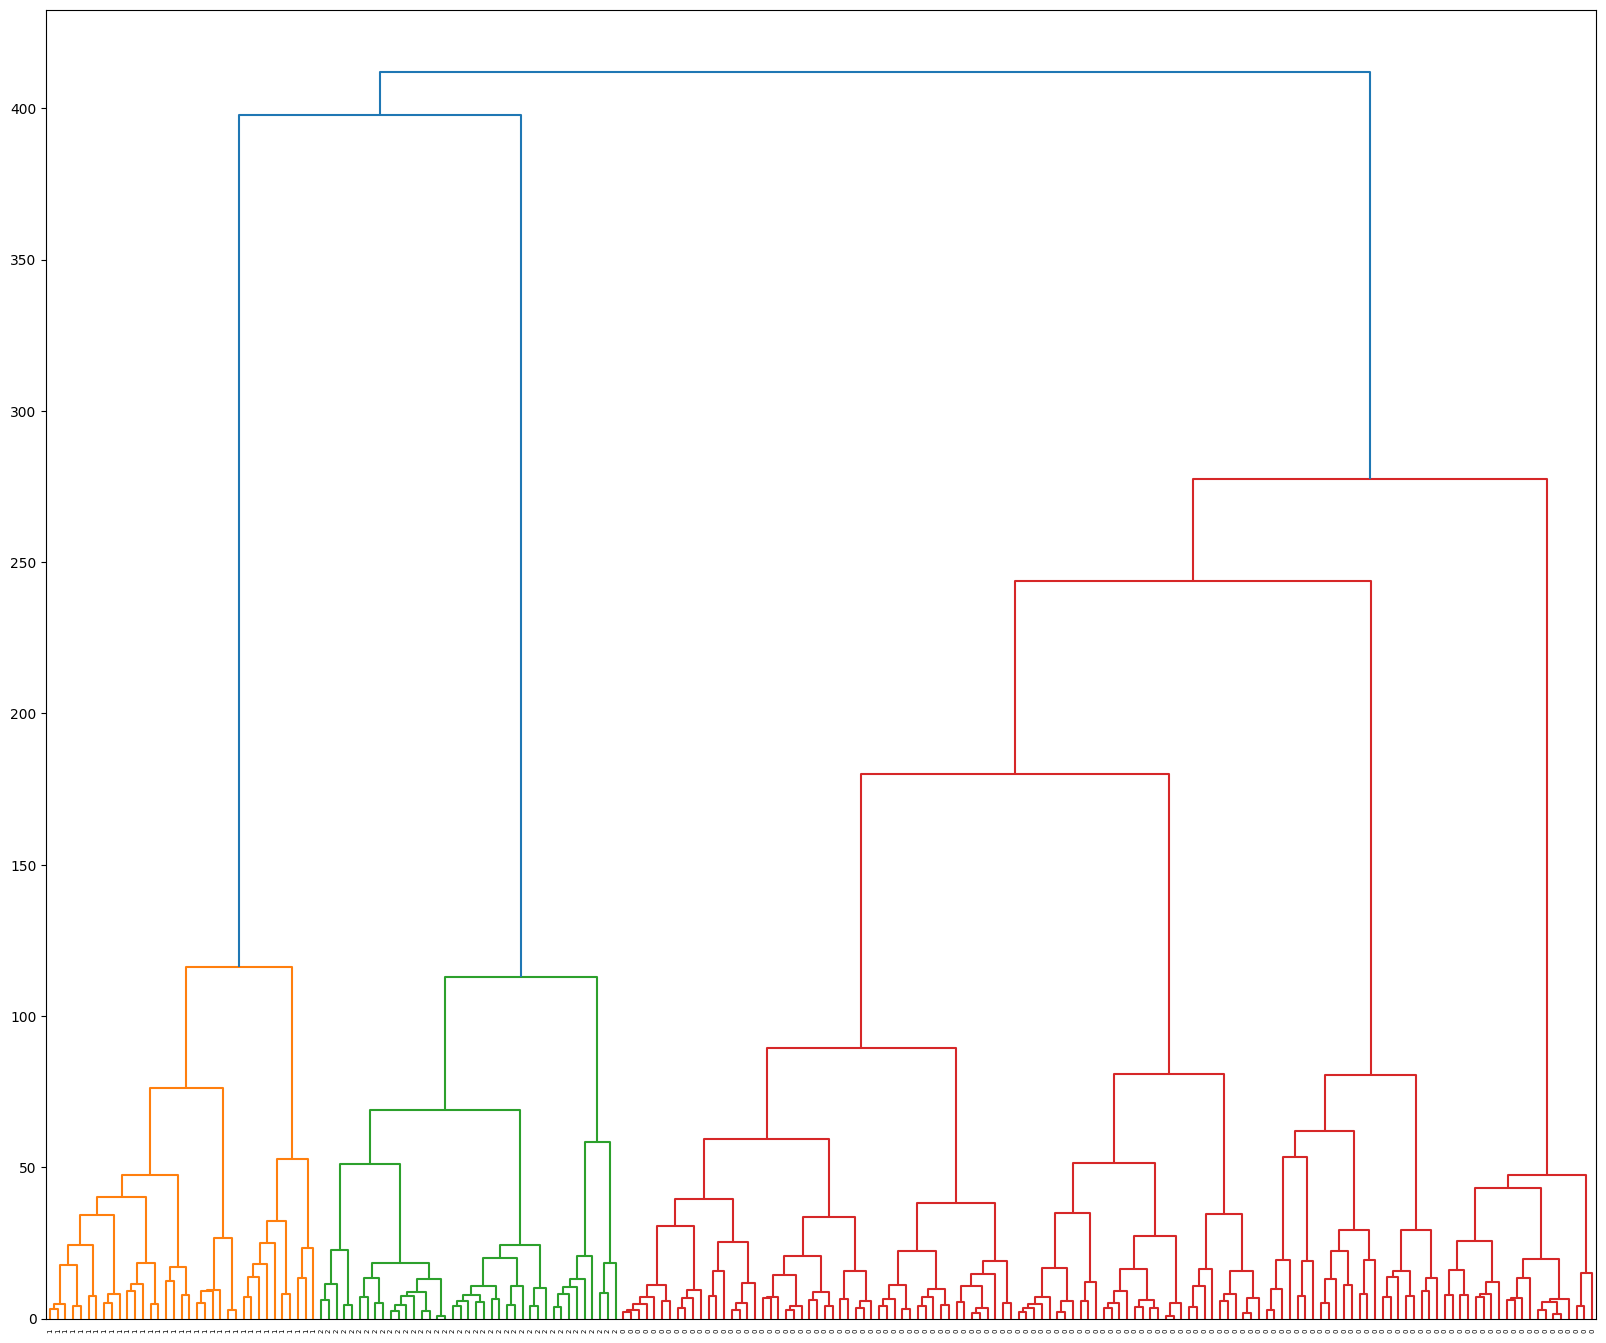

In [25]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

# расссчитаем расстояния между кластерами
linked = linkage(X, 'ward')

plt.figure(figsize=(20, 17))

# визуализируем дендрограмму с ориентацией top
# сначала будут отрисовываться кластеры с минимальным расстоянием между друг другом
dendrogram(Z=linked,
            orientation='top',
            labels=predictions_ag_model,
            distance_sort='descending')

plt.show()

Как мы можем судить из дендрограммы, если взять евклидово расстояние между кластерами, равное 150, датасет будет делиться на шесть кластеров.

Давайте визуально оценим, что из этого получилось. Для этого обучим модель агломеративной кластеризации с количеством кластеров, равным 6:

In [26]:
df['aggl_res_6'] = get_aggl_clustering(df[['age', 'annual_income', 'spending_score']], 6)
get_3d_visualization(df, 'aggl_res_6')

Итак, кластеры разделились хорошо.

Нам очень важно, чтобы в ходе кластеризации не были выделены лишние группы, так как это помешает анализу покупателей. Таким образом, нужно, чтобы кластеры получались максимально наполненными элементами. Лучше использовать метрику полноты можно вызвать из модуля cluster библиотеки sklearn. Метрика рассчитывается следующим образом:

In [31]:
from sklearn.metrics.cluster import completeness_score

print(completeness_score(labels_true=df.cluster, labels_pred=df.aggl_res_6))

0.9012847747610448


Судя по значению метрики, кластеризация проведена отлично: кластеры получились наполненными элементами, а значит данные результаты можно дальше использовать для анализа.